# Training models

## Imports

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
from data_preprocessing import (
    full_pipeline,
    split_classif_reg_targets,
)
from random_forest import run_experiment as run_random_forest_experiment
from random_forest import benchmark_random_forest
from two_stage import run_experiment as run_two_stage_experiment
from two_stage import benchmark_2s_model_grid, benchmark_2s_param_grid
from xg_boost import run_experiment as run_xgboost_experiment
from xg_boost import benchmark_xgboost
from nn import run_experiment as run_nn_experiment
from nn import submit_nn, compute_embeddings, compare_active_dimensions
from linreg import run_experiment as run_linreg_experiment
from utils import (
    write_submissions,
    evaluate_model,
    stratify_by_humidity,
    plot_avg_attention_maps,
)
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

## Load and prepare data

In [2]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

In [4]:
params_pipeline = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.5,
    "rescale": True,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "power_degree": 2,
    "include_group_interactions": True,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
    "cut_low_humidity": False,
}

test_params_pipeline = params_pipeline.copy()
test_params_pipeline["split"] = False
test_params_pipeline["split_humidity"] = False
test_params_pipeline["cut_low_humidity"] = False

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline
)
x_test = full_pipeline(test_x_path, None, **test_params_pipeline)

# Create stratified validation sets
if True:
    x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=5)
    val_data = [(x_val_strata[i], y_val_strata[i]) for i in range(len(x_val_strata))]
else:
    val_data = [(x_val, y_val)]
    labels = None
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X val shape:", x_val.shape)
print("Y val shape:", y_val.shape)
print("---")
print("X test shape:", x_test.shape)
print("---")

X train shape: (176676, 14)
Y train shape: (176676, 23)
X val shape: (26257, 14)
Y val shape: (26257, 23)
---
X test shape: (134673, 14)
---


0.5716792320405715


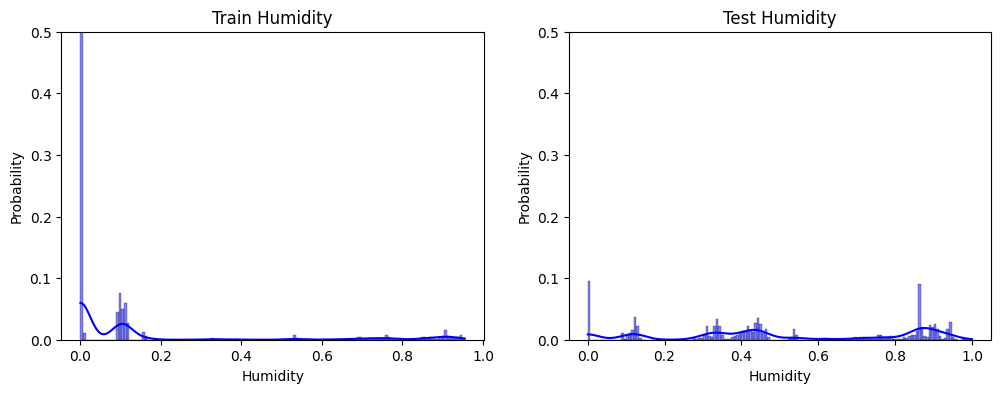

In [5]:
print(x_train[x_train["Humidity"] < 0.01]["Humidity"].count() / x_train.shape[0])

train_hum = x_train["Humidity"]
test_hum = x_test["Humidity"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(
    train_hum,
    bins=150,
    ax=ax[0],
    kde=True,
    stat="probability",
    color="blue",
    log_scale=False,
)
sns.histplot(
    test_hum,
    bins=150,
    ax=ax[1],
    kde=True,
    stat="probability",
    color="blue",
    log_scale=False,
)
ax[0].set_ylim([0, 0.5])
ax[1].set_ylim([0, 0.5])
ax[0].set_title("Train Humidity")
ax[1].set_title("Test Humidity")
plt.show()

In [7]:
params_pipeline_feateng = {
    "split_humidity": False,
    "h_threshold": 0.211,
    "split": True,
    "val_proportion": 0.2,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": True,
    "power_degree": 1,
    "include_group_interactions": False,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
    "cut_low_humidity": True,
}
test_params_pipeline_feateng = params_pipeline_feateng.copy()
test_params_pipeline_feateng["split"] = False
test_params_pipeline_feateng["split_humidity"] = False
test_params_pipeline_feateng["cut_low_humidity"] = False
feat_eng = True
if feat_eng:
    x_train_eng, y_train_eng, x_val_eng, y_val_eng = full_pipeline(
        train_x_path, train_y_path, **params_pipeline_feateng
    )
    x_test_eng = full_pipeline(test_x_path, None, **test_params_pipeline_feateng)
else:
    x_train_eng, y_train_eng, x_val_eng, y_val_eng = x_train, y_train, x_val, y_val
    x_test_eng = x_test
print("Train shape:", x_train_eng.shape)
print("Val shape:", x_val_eng.shape)
assert x_train_eng.shape[1] == x_test_eng.shape[1], (
    f"x_train and x_test have different number of features: "
    f"{x_train_eng.shape[1]} != {x_test_eng.shape[1]}."
    f"'ID' in train: {('ID' in x_train_eng.columns)},"
    f"'ID' in test: {('ID' in x_test_eng.columns)}."
)

Train shape: (105896, 40)
Val shape: (97037, 40)


## Standard Regressors

### Random Forest Regressor

In [9]:
print("Basic Random Forest")
rf_model = run_random_forest_experiment(x_train, y_train, x_val, y_val)

Basic Random Forest
Training Weighted RMSE: 0.1166
Validation Weighted RMSE: 0.2385


In [10]:
print("Basic Random Forest with Feature Engineering")
rf_model_eng = run_random_forest_experiment(
    x_train_eng, y_train_eng, x_val_eng, y_val_eng
)

Basic Random Forest with Feature Engineering
Training Weighted RMSE: 0.1148
Validation Weighted RMSE: 0.2367


In [15]:
x_train_eng.columns

Index(['ID', 'Humidity', 'M12', 'M13', 'M14', 'M15', 'M4', 'M5', 'M6', 'M7',
       'R', 'S1', 'S2', 'S3', 'Humidity_power_2', 'Humidity_root_2',
       'Humidity_M12_product', 'Humidity_M13_product', 'Humidity_M14_product',
       'Humidity_M15_product', 'Humidity_M4_product', 'Humidity_M5_product',
       'Humidity_M6_product', 'Humidity_M7_product', 'Humidity_R_product',
       'Humidity_S1_product', 'Humidity_S2_product', 'Humidity_S3_product',
       'Humidity_M12_ratio', 'Humidity_M13_ratio', 'Humidity_M14_ratio',
       'Humidity_M15_ratio', 'Humidity_M4_ratio', 'Humidity_M5_ratio',
       'Humidity_M6_ratio', 'Humidity_M7_ratio', 'Humidity_R_ratio',
       'Humidity_S1_ratio', 'Humidity_S2_ratio', 'Humidity_S3_ratio'],
      dtype='object')

In [8]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [7, 10, 15, None],
    "min_samples_split": [0.005, 0.01, 0.02],
    "min_samples_leaf": [20, 30, 50],
}
benchmark = False
if benchmark:
    try:
        best_model_rf, best_params_rf, best_val_rmse_rf = benchmark_random_forest(
            x_train,
            y_train,
            x_val,
            y_val,
            param_grid=param_grid,
            verbose=False,
            subset_humidity=False,
        )
    except KeyboardInterrupt:
        print("KeyboardInterrupt: Stopping the benchmarking process.")

In [11]:
best_params = {
    "n_estimators": 100,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "random_state": 29,
    "n_jobs": -1,
}

best_rf_model = run_random_forest_experiment(
    x_train, y_train, x_val, y_val, params=best_params
)

Training Weighted RMSE: 0.0714
Validation Weighted RMSE: 0.2441


### XGBoost

In [ ]:
param_grid = {
    "n_estimators": [100],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    # "min_child_weight": [5, 10, 15],
    # "gamma": [0, 0.1, 0.2],
    # "reg_alpha": [0, 0.1, 0.2],
    # "reg_lambda": [1, 1.5, 2],
}
benchmark = False
if benchmark:
    best_xgb_model, best_xgb_params, best_val_rmse_xgb = benchmark_xgboost(
        x_train,
        y_train,
        x_val,
        y_val,
        param_grid=param_grid,
        verbose=False,
        subset_humidity=False,
    )

In [ ]:
print(best_xgb_params)
print(best_val_rmse_xgb)

{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 29, 'n_jobs': -1, 'tree_method': 'approx', 'max_bin': 64, 'scale_pos_weight': 1, 'process_type': 'default', 'predictor': 'cpu_predictor', 'grow_policy': 'depthwise'}
0.03559214381771881


In [12]:
params = {
    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 29,
    "n_jobs": -1,
}
try:
    xgb = run_xgboost_experiment(x_train, y_train, x_val, y_val, params=params)
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training.")

Training Weighted RMSE (XGBoost): 0.0221
Validation Weighted RMSE (XGBoost): 0.2587


### Multi Linear Regression with feature selection

In [8]:
try:
    linear_model = run_linreg_experiment(
        x_train_eng, y_train_eng, x_val_eng, y_val_eng, alpha=0.05
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

Training SelectiveLinearRegressor model...


 61%|██████    | 14/23 [00:03<00:02,  4.17it/s]/Users/kiki/.pyenv/versions/idgaz/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
100%|██████████| 23/23 [00:05<00:00,  4.12it/s]


Feature selection results:
c01: 35 features selected - R^2 before selection: 0.6548206712608804 - R^2 after selection: 0.6548059996770834
c02: 34 features selected - R^2 before selection: 0.2744913595601457 - R^2 after selection: 0.27429763388688755
c03: 33 features selected - R^2 before selection: 0.45225098155223586 - R^2 after selection: 0.4521957842445906
c04: 33 features selected - R^2 before selection: 0.45225098155223586 - R^2 after selection: 0.4521957842445906
c05: 38 features selected - R^2 before selection: 0.41485140589447045 - R^2 after selection: 0.4148327496323242
c06: 38 features selected - R^2 before selection: 0.41485140589447045 - R^2 after selection: 0.4148327496323242
c07: 34 features selected - R^2 before selection: 0.2744913595601457 - R^2 after selection: 0.27429763388688755
c08: 36 features selected - R^2 before selection: 0.1473075908742535 - R^2 after selection: 0.14723767645558705
c09: 36 features selected - R^2 before selection: 0.27992740966577323 - R^2 af

100%|██████████| 23/23 [00:00<00:00, 60.64it/s]


Training Weighted RMSE: 0.1622
Validation Weighted RMSE: 0.2373


In [9]:
evaluate_model(linear_model, x_val_eng, y_val_eng)

100%|██████████| 23/23 [00:00<00:00, 56.78it/s]


0.23732612520123392

In [10]:
write_submissions(
    linear_model,
    test_x_path,
    "submissions/multi_regression_feateng.csv",
    use_embed=False,
    **test_params_pipeline_feateng,
)

Using 39 features


100%|██████████| 23/23 [00:00<00:00, 55.16it/s]


## Deep Learning

### Load Data

In [2]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

split_humidity = False
params_pipeline_dl = {
    "split_humidity": split_humidity,
    "h_threshold": 0.211,
    "split": not split_humidity,
    "val_proportion": 0.5 if split_humidity else 0.1,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "power_degree": 2,
    "include_group_interactions": False,
    "include_humidity_interactions": False,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
    "cut_low_humidity": False,
}

test_params_pipeline_dl = params_pipeline_dl.copy()
test_params_pipeline_dl["split"] = False
test_params_pipeline_dl["split_humidity"] = False
test_params_pipeline_dl["cut_low_humidity"] = False

x_train, y_train, x_val, y_val = full_pipeline(train_x_path, train_y_path, **params_pipeline_dl)
# concat train and val
# x_train = pd.concat([x_train, x_val], axis=0)
# y_train = pd.concat([y_train, y_val], axis=0)
x_test = full_pipeline(test_x_path, None, **test_params_pipeline_dl)
print("Train shape:", x_train.shape)
print("Val shape:", x_val.shape)

if True:
    x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=5)
    val_data = [(x_val_strata[i], y_val_strata[i]) for i in range(len(x_val_strata))]
else:
    val_data = [(x_val, y_val)]
    labels = None

if True:
    val_data = val_data[-3:]
    labels = labels[-3:]

ranges = [[float(s[6:10]), float(s[12:16])] for s in labels]
for ran in ranges:
    print(f"Range: {ran[0]} - {ran[1]}")
    print(
        f"train size: {x_train[(x_train['Humidity'] >= ran[0]) & (x_train['Humidity'] < ran[1])].shape[0]}, = {x_train[(x_train['Humidity'] >= ran[0]) & (x_train['Humidity'] < ran[1])].shape[0] / x_train.shape[0] * 100:.2f}%"
    )
    print(
        f"val size: {x_val[(x_val['Humidity'] >= ran[0]) & (x_val['Humidity'] < ran[1])].shape[0]}, = {x_val[(x_val['Humidity'] >= ran[0]) & (x_val['Humidity'] < ran[1])].shape[0] / x_val.shape[0] * 100:.2f}%"
    )

Train shape: (182639, 14)
Val shape: (20294, 14)
Range: 0.0 - 0.1
train size: 108875, = 59.61%
val size: 12248, = 60.35%
Range: 0.1 - 0.69
train size: 36880, = 20.19%
val size: 3896, = 19.20%
Range: 0.69 - 1.0
train size: 36884, = 20.20%
val size: 4150, = 20.45%


### RAMTNet
#### Without UDA

In [14]:
params_ramt = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": 13,
        "num_tasks": 23,
        "feature_embed_dim": 16,
        "embed_dim": 128,
        "attn_heads": 4,
        "attn_blocks": 2,
        "num_res_blocks": 1,
        "res_hidden": 32,
        "head_hidden": 32,
        "enc_dropout_rate": 0.4,
        "head_dropout_rate": 0.4,
    },
    "training_params": {
        "n_epochs": 150,
        "lr": 5e-4,
        "weight_decay": 1e-4,
        "batch_size": 2048,
        "patience": 12,
        "factor": 0.5,
        "min_lr": 1e-7,
        "lr_warmup_epochs": 2,
        "loss": "WeightedMSELoss",
    },
}

In [ ]:
try:
    ramtnet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        params=params_ramt,
        uda=False,
        uda_hidden_dim=32,
        uda_dropout_rate=0.0,
        warmup_epochs=150,
        gamma=10.0,
        uda_phase_lr=5e-4,
        uda_disc_lr=5e-4,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

Number of trainable parameters (encoder + head): 29408 + 31415 = 60823


Train Loss: 0.2000, Val Loss: 0.1780, LR: 0.000500:   3%|▎         | 4/150 [00:54<32:37, 13.41s/it]

Computing attention maps: 100%|██████████| 182639/182639 [00:02<00:00, 62669.12batches/s]


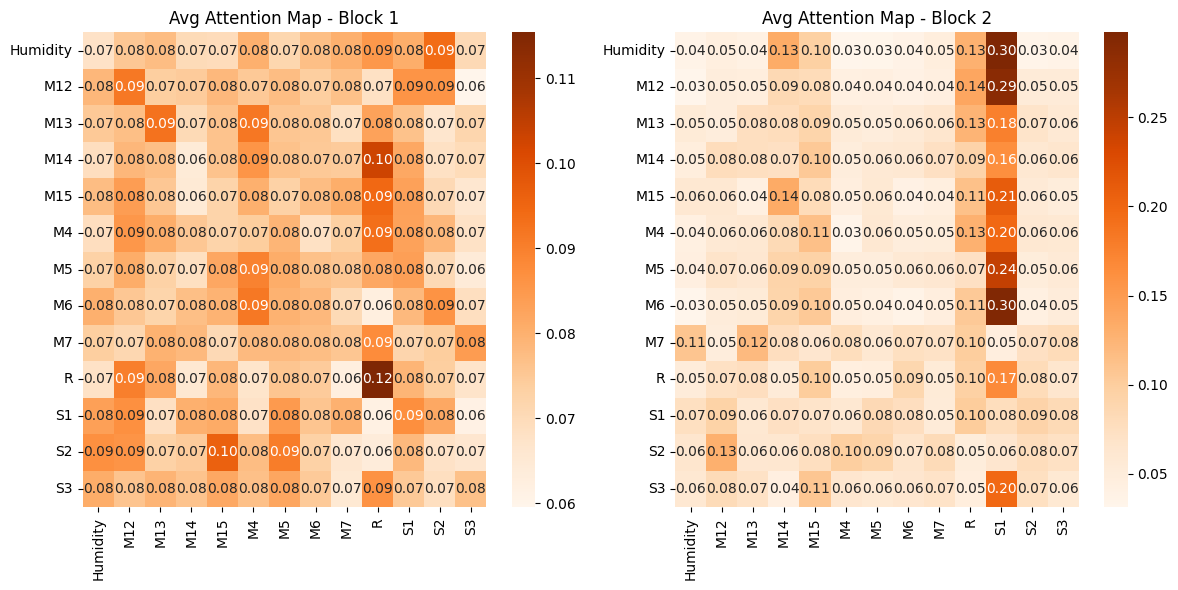

In [ ]:
plot_avg_attention_maps(ramtnet, x_train, batch_size=2048, cmap="Oranges")

Embedding dimension: 128
Average active dimensions in train: 75.91 (59.30%)
Average active dimensions in test: 76.53 (59.79%)
---
Max active dimensions in train: 96.0
Max active dimensions in test: 96.0


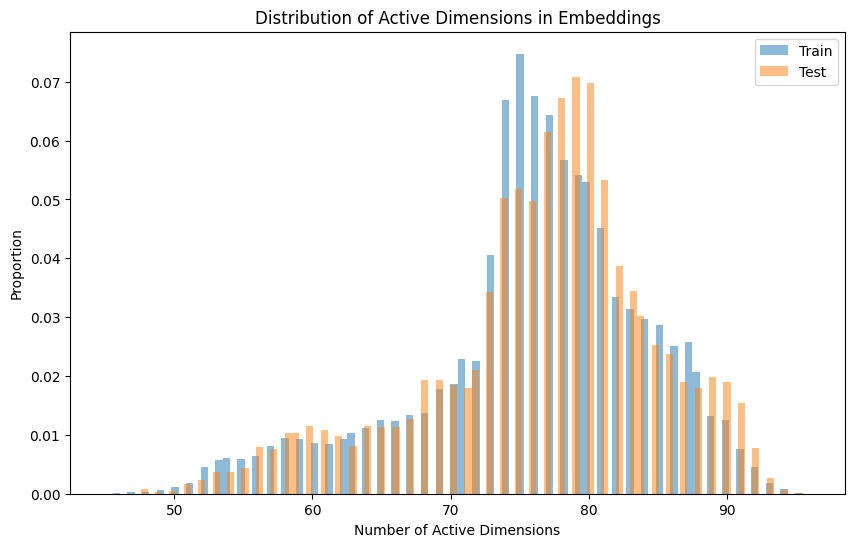

In [ ]:
train_embeddings, val_embeddings, test_embeddings = compute_embeddings(
    ramtnet, x_train, x_val, x_test
)
compare_active_dimensions(train_embeddings, None, test_embeddings)

In [ ]:
evaluate_model(ramtnet, x_train, y_train)

In [ ]:
evaluate_model(ramtnet, x_val, y_val)

0.17541501490678008

base: 29408 + 274967 = 304375 params 

0.04542143556514001 <br>
Validation error H in [0.00, 0.10]: 0.029650440904473684 <br>
Validation error H in [0.10, 0.69]: 0.058222544029627184 <br>
Validation error H in [0.69, 1.00]: 0.04653461003067317 <br>

lighter head: 29408 + 114007 = 143415 params

0.04928691756430588 <br>
Validation error H in [0.00, 0.10]: 0.038315182926940326 <br>
Validation error H in [0.10, 0.69]: 0.06030216135444513 <br>
Validation error H in [0.69, 1.00]: 0.05313241597114303 <br>

In [ ]:
for i, (x, y) in enumerate(val_data):
    error = evaluate_model(ramtnet, x, y)
    print(f"Validation error {labels[i]}: {error}")

Validation error H in [0.00, 0.10]: 0.1391022726251437
Validation error H in [0.10, 0.69]: 0.20538922483858948
Validation error H in [0.69, 1.00]: 0.16920419805329395


In [ ]:
torch.save(ramtnet.state_dict(), "checkpoints/ramtnet_s.pth")

#### With UDA

In [14]:
params_ramt_uda = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": 13,
        "num_tasks": 23,
        "feature_embed_dim": 16,
        "embed_dim": 128,
        "attn_heads": 4,
        "attn_blocks": 2,
        "num_res_blocks": 2,
        "res_hidden": 128,
        "head_hidden": 64,
        "enc_dropout_rate": 0.5,
        "head_dropout_rate": 0.5,
    },
    "training_params": {
        "n_epochs": 250,
        "lr": 2.5e-4,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": 12,
        "factor": 0.5,
        "min_lr": 1e-6,
        "lr_warmup_epochs": 10,
        "loss": "WeightedRMSELoss",
    },
}

In [ ]:
# shuffle x_test
x_test = x_test.sample(frac=1).reset_index(drop=True)

Number of trainable parameters (encoder + head + domain discriminator): 29408 + 274967 + 4225 = 308600
Warming up encoder for 150 epochs. No domain adaptation yet.


Disc Acc: 0.00%, Disc Loss: 0.0000, Lambda: 0.000000, Train Reg Loss: 0.0717, Val Loss: 0.0726, LR: 0.000250:  60%|██████    | 150/250 [35:12<24:31, 14.71s/it]

Domain adaptation enabled.


Disc Acc: 69.47%, Disc Loss: 0.5774, Lambda: 0.999909, Train Reg Loss: 0.1195, Val Loss: 0.1041, LR: 0.000002: 100%|██████████| 250/250 [1:12:23<00:00, 17.37s/it]


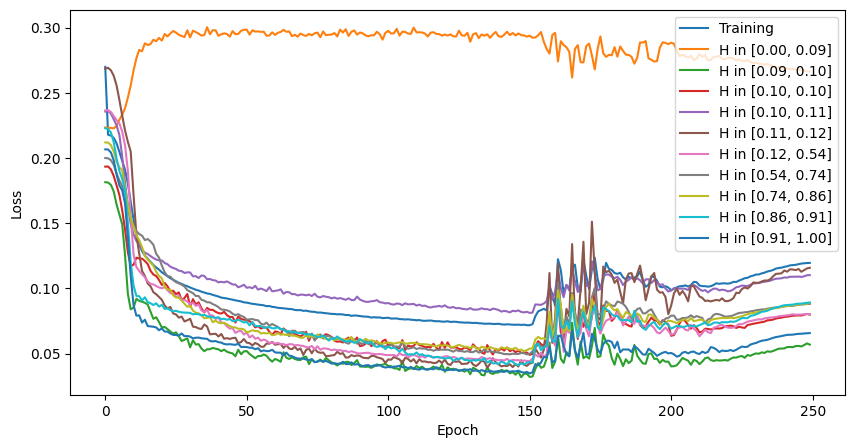

In [16]:
try:
    ramtnet_uda = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        params=params_ramt_uda,
        uda=True,
        uda_hidden_dim=32,
        uda_dropout_rate=0.0,
        warmup_epochs=150,
        gamma=10.0,
        uda_phase_lr=2.5e-4,
        uda_disc_lr=2.5e-4,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

Computing attention maps: 100%|██████████| 146529/146529 [00:02<00:00, 62568.59batches/s]


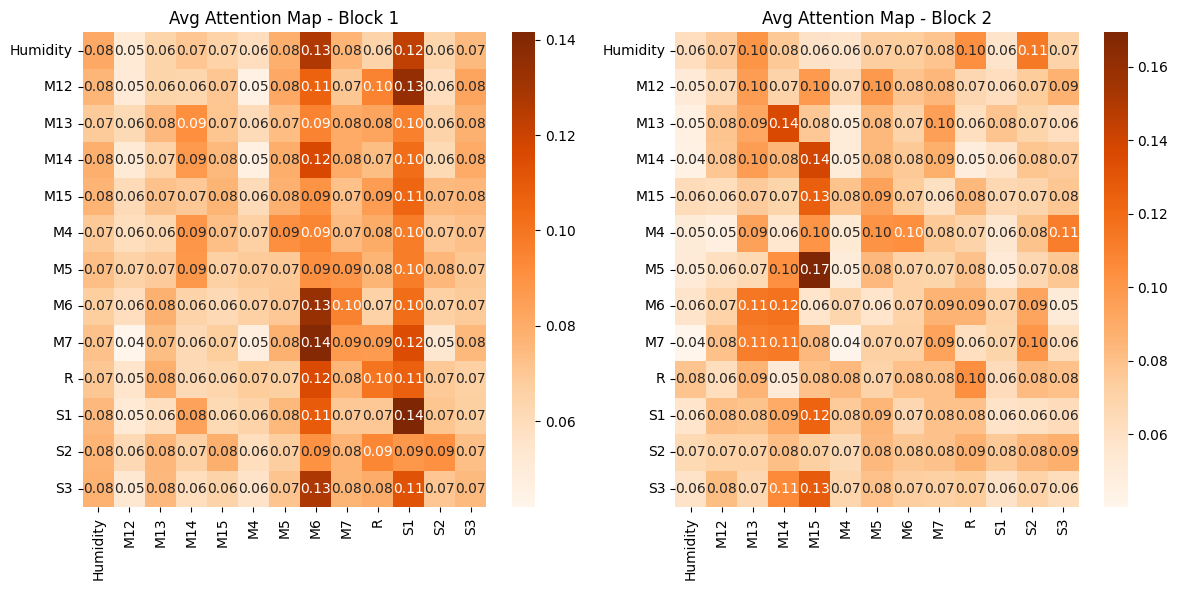

In [17]:
plot_avg_attention_maps(ramtnet_uda, x_train, batch_size=2048, cmap="Oranges")

Embedding dimension: 128
Average active dimensions in train: 14.02 (10.96%)
Average active dimensions in test: 15.43 (12.06%)
---
Max active dimensions in train: 52.0
Max active dimensions in test: 48.0


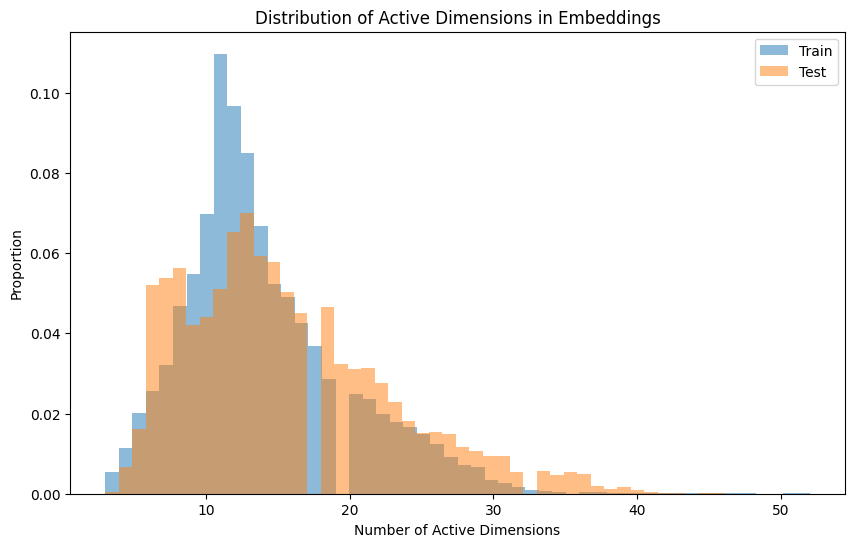

In [18]:
train_embeddings_uda, _, test_embeddings_uda = compute_embeddings(
    ramtnet_uda, x_train, None, x_test
)
compare_active_dimensions(train_embeddings_uda, None, test_embeddings_uda)

Embedding dimension: 128 <br>
Average active dimensions in train: 30.65 (23.94%)<br>
Average active dimensions in test: 31.29 (24.45%)<br>


Max active dimensions in train: 60.0<br>
Max active dimensions in test: 58.0<br>

In [19]:
evaluate_model(ramtnet_uda, x_train, y_train)

0.08479272851196812

In [20]:
evaluate_model(ramtnet_uda, x_val, y_val)

0.23961044332123552

0.103498861107991

In [21]:
for i, (x, y) in enumerate(val_data):
    error = evaluate_model(ramtnet_uda, x, y)
    print(f"Validation error {labels[i]}: {error}")

Validation error H in [0.00, 0.09]: 0.26627064891192426
Validation error H in [0.09, 0.10]: 0.0568232610584333
Validation error H in [0.10, 0.10]: 0.07986681680811372
Validation error H in [0.10, 0.11]: 0.11014232483686462
Validation error H in [0.11, 0.12]: 0.11576104640045333
Validation error H in [0.12, 0.54]: 0.08028609778784447
Validation error H in [0.54, 0.74]: 0.08806711810929914
Validation error H in [0.74, 0.86]: 0.08873676081168075
Validation error H in [0.86, 0.91]: 0.08913535476245779
Validation error H in [0.91, 1.00]: 0.06568557083284576


Validation error H in [0.00, 0.10]: 0.08783645966947218<br>
Validation error H in [0.10, 0.69]: 0.12021063909758498<br>
Validation error H in [0.69, 1.00]: 0.09779249282548434<br>

In [22]:
torch.save(ramtnet_uda.state_dict(), "checkpoints/ramtnet_final_uda_s2_250.pth")

### NNRegressor

First simple DL model.

In [12]:
epochs = 100
params_nnreg = {
    "model_class": "NNRegressor",
    "model_params": {
        "hidden_dim": 256,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
        "lr_warmup_epochs": 2,
    },
}

Number of trainable parameters: 41111


Train Loss: 0.0678, Val Loss: 0.0473, LR: 0.000500: 100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


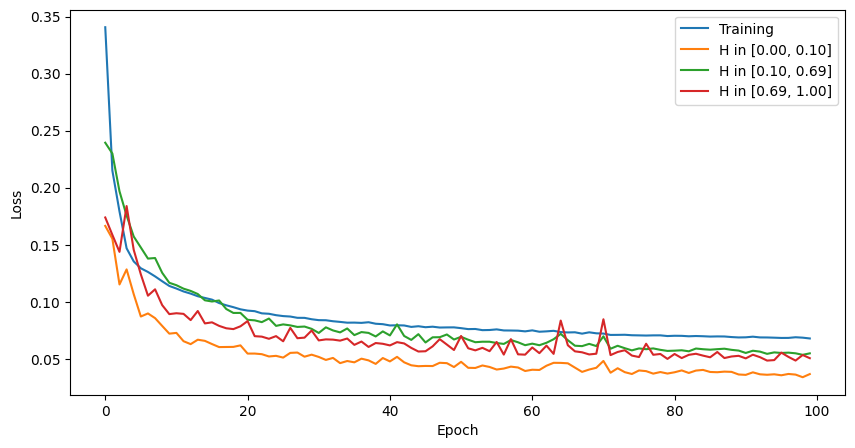

In [13]:
try:
    nnreg = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_nnreg,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [14]:
print(f"Weighted RMSE on validation set: {evaluate_model(nnreg, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.0465


In [15]:
for i, (x, y) in enumerate(val_data):
    error = evaluate_model(nnreg, x, y)
    print(f"Validation error {labels[i]}: {error}")

Validation error H in [0.00, 0.10]: 0.0366130127451013
Validation error H in [0.10, 0.69]: 0.054776390136657256
Validation error H in [0.69, 1.00]: 0.05053280713464462


In [ ]:
torch.save(nnreg.state_dict(), "checkpoints/nnreg_base.pth")

### CNN

In [16]:
epochs = 100
params_cnn = {
    "model_class": "SensorCNN",
    "model_params": {
        "input_dim": x_train.drop("ID", axis=1).shape[1],
        "embed_dim": 16,
        "conv_channels": 64,
        "final_dim": 128,
        "num_output": y_train.shape[1],
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
        "lr_warmup_epochs": 2,
    },
}

Number of trainable parameters: 142839


Train Loss: 0.1030, Val Loss: 0.0774, LR: 0.000250: 100%|██████████| 100/100 [17:35<00:00, 10.56s/it]


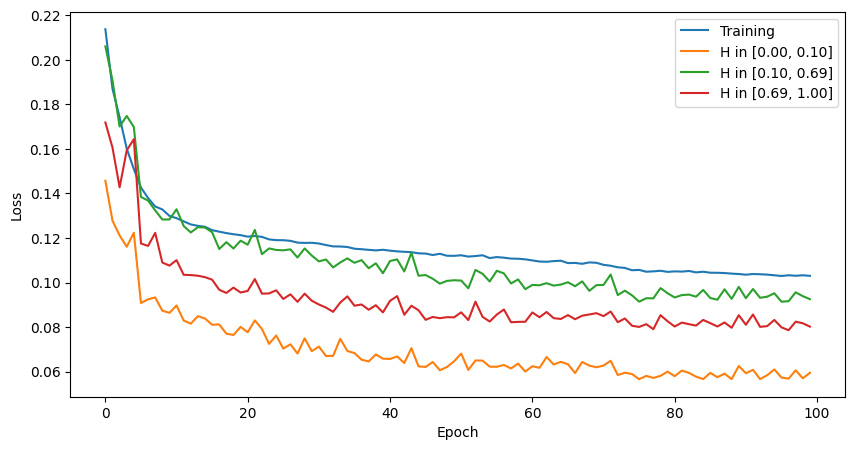

In [17]:
try:
    cnn = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_cnn,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [18]:
error = evaluate_model(cnn, x_val, y_val)
print(f"Validation error: {error}")

Validation error: 0.07917468460657394


In [19]:
for i, (x, y) in enumerate(val_data):
    error = evaluate_model(cnn, x, y)
    print(f"Validation error {labels[i]}: {error}")

Validation error H in [0.00, 0.10]: 0.05948030865940309
Validation error H in [0.10, 0.69]: 0.09253121724118857
Validation error H in [0.69, 1.00]: 0.08020578345675146


In [20]:
torch.save(cnn.state_dict(), "checkpoints/cnn_base.pth")

## Two-stage approach

In [6]:
y_train_classif, y_train_reg = split_classif_reg_targets(y_train)
y_val_classif, y_val_reg = split_classif_reg_targets(y_val)

In [ ]:
model_grid = {
    "clf_names": [
        "randomforestclassifier",
        "decisiontreeclassifier",
        "kneighborsclassifier",
        "xgbclassifier",
    ],
    "reg_names": [
        "randomforestregressor",
        "linearregression",
        "decisiontreeregressor",
        "kneighborsregressor",
        "xgbregressor",
        "gradientboostingregressor",
    ],
    "clf_params": {
        "randomforestclassifier": {
            "n_estimators": 10,
            "max_depth": 10,
            "random_state": 29,
            "n_jobs": -1,
        },
        "decisiontreeclassifier": {"max_depth": 10, "random_state": 29},
        "kneighborsclassifier": {"n_neighbors": 5, "n_jobs": -1},
        "xgbclassifier": {"n_estimators": 10, "max_depth": 10, "random_state": 29},
    },
    "reg_params": {
        "randomforestregressor": {
            "n_estimators": 10,
            "max_depth": 10,
            "random_state": 29,
            "n_jobs": -1,
        },
        "linearregression": {"n_jobs": -1},
        "decisiontreeregressor": {"max_depth": 10, "random_state": 29},
        "kneighborsregressor": {"n_neighbors": 5, "n_jobs": -1},
        "xgbregressor": {
            "n_estimators": 10,
            "max_depth": 10,
            "random_state": 29,
            "n_jobs": -1,
        },
        "gradientboostingregressor": {
            "n_estimators": 10,
            "max_depth": 10,
            "random_state": 29,
        },
    },
}

try:
    best_model_2s, best_params_2s, best_val_rmse_2s = benchmark_2s_model_grid(
        x_train,
        y_train,
        y_train_classif,
        y_train_reg,
        x_val,
        y_val,
        y_val_classif,
        y_val_reg,
        model_grid,
        verbose=True,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping the benchmarking process.")

In [ ]:
clf_name = "randomforestclassifier"
reg_name = "randomforestregressor"
param_grid = {
    "clf": {
        "n_estimators": [100, 200],
        "max_depth": [15, None],
        "min_samples_split": [0.005],
        "min_samples_leaf": [30, 50],
    },
    "reg": {
        "n_estimators": [100, 200],
        "max_depth": [15, None],
        "min_samples_split": [0.005],
        "min_samples_leaf": [30, 50],
    },
}

try:
    best_model_2s, best_params_2s, best_val_rmse_2s = benchmark_2s_param_grid(
        x_train,
        y_train,
        y_train_classif,
        y_train_reg,
        x_val,
        y_val,
        y_val_classif,
        y_val_reg,
        clf_name,
        reg_name,
        param_grid,
        verbose=True,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping the benchmarking process.")

In [ ]:
print(evaluate_model(best_model_2s, x_train, y_train))
print(evaluate_model(best_model_2s, x_val, y_val))

In [7]:
clf_params = {
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "n_jobs": -1,
}
reg_params = {
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "n_jobs": -1,
}

two_stage_model = run_two_stage_experiment(
    x_train,
    y_train,
    y_train_classif,
    y_train_reg,
    x_val,
    y_val,
    y_val_classif,
    y_val_reg,
    clf_name="randomforestclassifier",
    reg_name="randomforestregressor",
    clf_params=clf_params,
    reg_params=reg_params,
)

Training Weighted RMSE: 0.0701
Validation Weighted RMSE: 0.1000
Validation Accuracy of Classifier: 0.9870


In [8]:
evaluate_model(two_stage_model, x_val, y_val)

0.09996867736303013

In [9]:
for i, (x, y) in enumerate(val_data):
    error = evaluate_model(two_stage_model, x, y)
    print(f"Validation error {labels[i]}: {error}")

Validation error H in [0.00, 0.68]: 0.11894545832911886
Validation error H in [0.68, 0.76]: 0.11513669914452784
Validation error H in [0.76, 0.87]: 0.08905959616663547
Validation error H in [0.87, 0.91]: 0.08843071284646806
Validation error H in [0.91, 1.00]: 0.08255936720882541


## Predict

In [ ]:
submit_nn(
    "checkpoints/ramtnet_enc128_best.pth",
    "RAMTNet",
    params_ramt["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/ramtnet_enc128_best.csv",
)

Using 13 features
